In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.mask import mask
from rasterio.fill import fillnodata
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box



In [2]:
# Open the GeoPackage vector file using GeoPandas
vector_file = "../../Land_Surface_Temperature/data/raw_data/3DBAG/Amsterdam_buildings.gpkg"
gdf = gpd.read_file(vector_file)


In [3]:
# Open the raster file using Rasterio
raster_file = "../data/raw_data/ahn/R_25GN1.TIF"
with rasterio.open(raster_file) as src:
    raster_data = src.read(1)
    raster_transform = src.transform

In [2]:
# Open the GeoPackage vector file using GeoPandas
vector_file = "../../Land_Surface_Temperature/data/raw_data/3DBAG/Amsterdam_buildings.gpkg"
gdf = gpd.read_file(vector_file)
gdf['geometry'] = gdf['geometry'].buffer(1)

# Open the raster file using Rasterio
raster_file = "../data/raw_data/ahn/R_25GN1.TIF"
with rasterio.open(raster_file) as src:
    # Reproject the vector layer to match the raster's CRS (32631)
    gdf = gdf.to_crs(src.crs)

    # Read the raster data
    raster_data = src.read()
    raster_transform = src.transform
    nodata = src.nodata

    # Create a mask of nodata areas
    nodata_mask = raster_data == nodata

    # Create a valid data mask
    valid_data_mask = ~nodata_mask

    # Fill nodata areas using rasterio's fillnodata function
    filled_data = fillnodata(raster_data, mask=valid_data_mask, max_search_distance=10)

    print(nodata)

    # Create a mask of the polygons on the raster
    mask = geometry_mask(gdf['geometry'], out_shape=raster_data.shape[1:], transform=raster_transform)

    # Check if any pixels are masked
    if mask.sum() == 0:
        print("Warning: No overlapping pixels found.")
    else:
        # Set pixel values where polygons overlap to 0
        for band in range(raster_data.shape[0]):
            # Ensure mask and raster data have the same dimensions
            if mask.shape != filled_data[band].shape:
                raise ValueError("Mask and raster data dimensions do not match.")
            # Apply mask to filled data
            filled_data[band][mask] = 0

    # Write the modified raster data to a new raster file
    output_file = "../data/clean_data/masked_raster.tif"
    with rasterio.open(output_file, 'w', driver='GTiff', width=filled_data.shape[2], height=filled_data.shape[1], count=filled_data.shape[0], dtype=filled_data.dtype, crs=src.crs, transform=raster_transform, nodata=nodata) as dst:
        dst.write(filled_data)


3.4028234663852886e+38


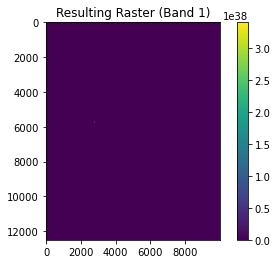

In [3]:
# Plot the resulting raster (you can choose a band to visualize)
# For example, to plot the first band:
plt.imshow(raster_data[0], cmap='viridis')
plt.colorbar()
plt.title('Resulting Raster (Band 1)')dd
plt.show()

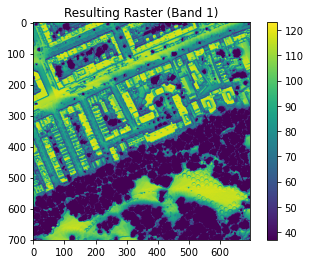

In [25]:
# Plot the resulting raster (you can choose a band to visualize)
# For example, to plot the first band:
plt.imshow(raster_data[7], cmap='viridis')
plt.colorbar()
plt.title('Resulting Raster (Band 1)')
plt.show()

In [26]:
# Calculate per pixel shade index
for band in range(raster_data.shape[0]):
    max_value = np.max(raster_data[band])
    raster_data[band] = 1 - (raster_data[band]/max_value)

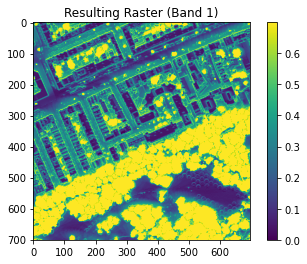

In [30]:
# Plot the resulting raster (you can choose a band to visualize)
# For example, to plot the first band:
plt.imshow(raster_data[7], cmap='viridis')
plt.colorbar()
plt.title('Resulting Raster (Band 1)')
plt.show()

In [32]:
# Save the modified raster including all bands
output_raster_file = "../results/output/2230_shade_index.tif"
with rasterio.open(output_raster_file, 'w', driver='GTiff', width=raster_data.shape[2], height=raster_data.shape[1], count=raster_data.shape[0], dtype=raster_data.dtype, crs=src.crs, transform=raster_transform) as dest:
    for band_idx in range(raster_data.shape[0]):
        dest.write(raster_data[band_idx], band_idx + 1)

# shade index average on verhardingen

In [2]:
# Open the raster file using Rasterio to get its extent
shade_index = "../results/output/2230_shade_index.tif"
with rasterio.open(shade_index) as src:
    shade_extent = src.bounds
    raster_bbox = box(src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top)
    raster_crs = src.crs


In [40]:
shade_extent

BoundingBox(left=626629.5, bottom=5802369.5, right=626978.5, top=5802720.0)

<AxesSubplot:>

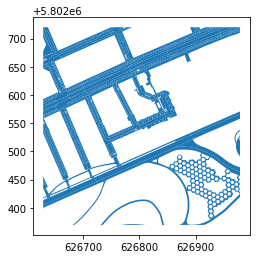

In [3]:
# Open the GeoPackage vector file using GeoPandas, filtering by the raster extent
verhardingen_file = "../../Land_Surface_Temperature/data/raw_data/AMS/verhardingen/Q1_20230126_ingekort.gpkg"
verhardingen = gpd.read_file(verhardingen_file).to_crs(raster_crs)
#No need to intersect, can directly clip.
#verhardingen = verhardingen[verhardingen.intersects(raster_bbox)]
verhardingen = verhardingen.clip(raster_bbox)
verhardingen.plot()


<AxesSubplot:>

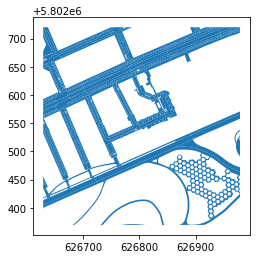

In [4]:
#Calculate shade index per verhardingen surface for all of the months and add them as individual columns.
with rasterio.open(shade_index) as src:
    # Read the raster bands
    bands = [src.read(band_idx) for band_idx in range(1, src.count + 1)]
    # Get the raster's spatial reference
    crs = src.crs
     # Iterate over the polygons
    for index, row in verhardingen.iterrows():
        polygon = row['geometry']
        # Initialize a list to store average values for each band
        average_values = []
        # Iterate over the bands
        for band_idx, band in enumerate(bands):
            # Use the polygon to clip the band
            clipped_band, _ = rasterio.mask.mask(src, [polygon], crop=True, nodata=np.nan, indexes=band_idx + 1)
            # Calculate the average pixel value for this band within the polygon
            average_pixel_value = np.nanmean(clipped_band)
            average_values.append(average_pixel_value)
        # Add the average pixel values to new columns in the GeoDataFrame
        for band_idx, avg_value in enumerate(average_values):
            verhardingen.at[index, f'Shade_index_M_{band_idx+1}'] = avg_value

/var/folders/qg/ghhvk02j7t3f3b9th5d2412rxxy23f/T/ipykernel_92376/543024968.py:17: RuntimeWarning: Mean of empty slice
  average_pixel_value = np.nanmean(clipped_band)


In [5]:
# Save for vis.
verhardingen_repr = verhardingen.to_crs(4326)
verhardingen_repr.to_file('../results/output/2230_shade_index.geojson', driver='GeoJSON')

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Checking whether the verhardingen dataset overlaps correctly.

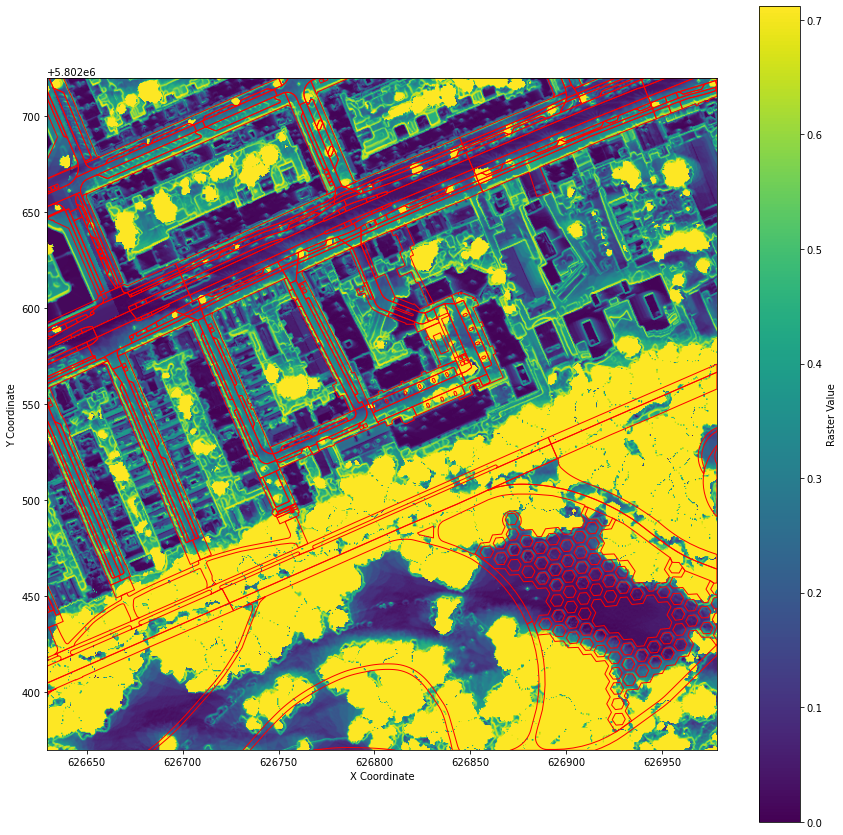

In [6]:
with rasterio.open(shade_index) as src:
    # Read the raster data for visualization (you can choose a specific band if needed)
    raster_data = src.read(7)  # Replace "1" with the band index you want to visualize
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]



# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the raster data
cax = ax.imshow(raster_data, cmap='viridis', extent=raster_extent, origin='upper')

# Plot the vector data on top
verhardingen.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

# Add a colorbar for the raster
plt.colorbar(cax, ax=ax, label='Raster Value')

# Set axis labels
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Show the plot
plt.show()

In [7]:
# Save the GeoDataFrame with the new columns
output_vector_file = "2230_verhardingen_shade_index.gpkg"
gdf.to_file(output_vector_file, driver='GPKG')

NameError: name 'gdf' is not defined